# CAVA Stock Price Prediction
### kaltonphxn
Predicting the stock price of Cava using its stock data pulled from Yahoo Finance using SRIMA and Linear Regression

## Pre-Processing

In [ ]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [6]:
#Read in data set
data = pd.read_csv(r'D:\Projects\CAVA_closing_prices.csv')
data.head()

,Price,Close
0,Ticker,CAVA
1,Date,NaN
2,2023-06-16,38.150001525878906
3,2023-06-20,38.43000030517578
4,2023-06-21,38.34000015258789


In [ ]:
# Clean formatting
data_cleaned = data.iloc[2:].reset_index(drop=True)
data_cleaned.columns = ["Date", "Close"]
data_cleaned["Date"] = pd.to_datetime(data_cleaned["Date"])
data_cleaned["Close"] = pd.to_numeric(data_cleaned["Close"], errors="coerce")
print(data_cleaned.head())
data_cleaned.to_csv("CAVA_cleaned.csv", index=False)

        Date      Close
0 2023-06-16  38.150002
1 2023-06-20  38.430000
2 2023-06-21  38.340000
3 2023-06-22  39.160000
4 2023-06-23  40.150002


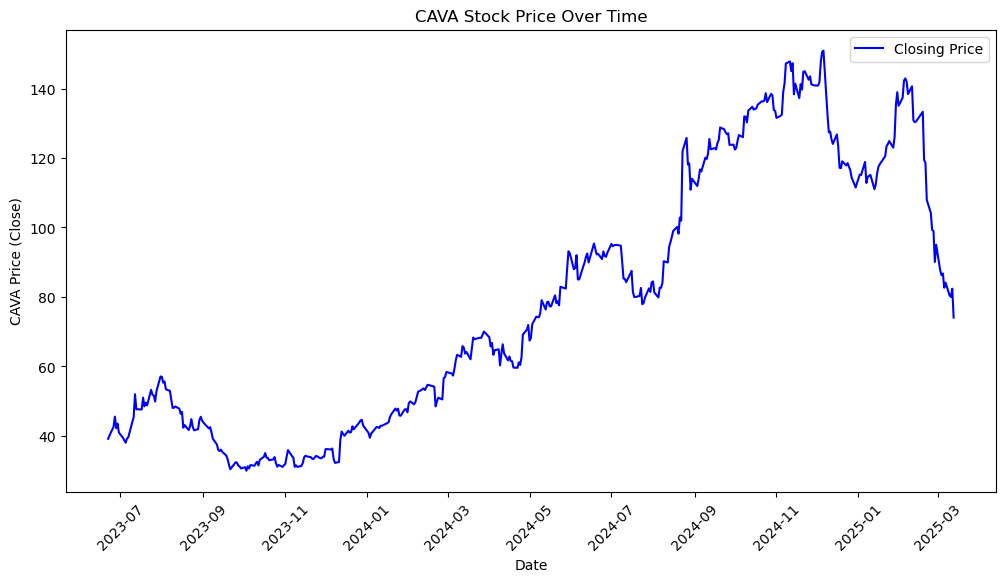

In [20]:
# Plot closing price over time
plt.figure(figsize=(12, 6))
plt.plot(data_cleaned["Date"], data_cleaned["Close"], linestyle='-', color='b', label="Closing Price")
plt.xlabel("Date")
plt.ylabel("CAVA Price (Close)")
plt.title("CAVA Stock Price Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

# Ensure the data is sorted by date (important for time-series)
data_cleaned = data_cleaned.sort_values(by="Date").reset_index(drop=True)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Compute split indices
total_samples = len(data_cleaned)
train_end = int(total_samples * train_ratio)
val_end = train_end + int(total_samples * val_ratio)

# Perform the split
train_data = data_cleaned.iloc[:train_end]  # Training set
val_data = data_cleaned.iloc[train_end:val_end]  # Validation set
test_data = data_cleaned.iloc[val_end:]  # Test set

# Display the split sizes
print(f"Train set: {len(train_data)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")

Train set: 305 samples
Validation set: 65 samples
Test set: 66 samples


## SARIMA

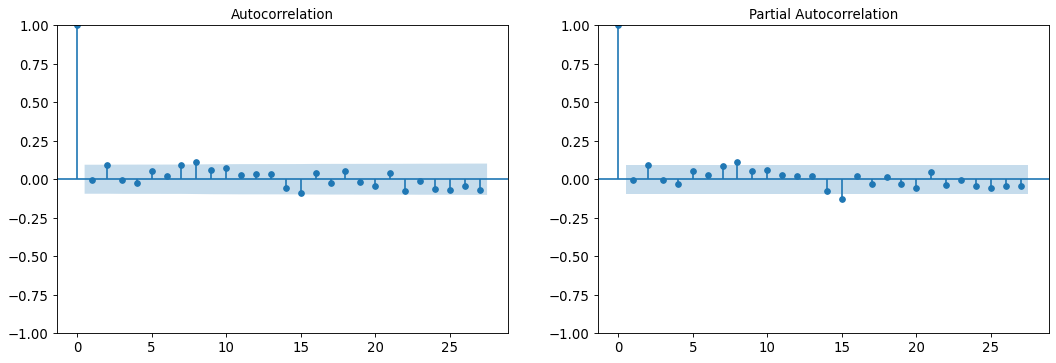

In [17]:
#Plot PACF and ACF to determine SARIMA parameters
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#Ensure the data is sorted by date
data_cleaned = data_cleaned.sort_values(by="Date").reset_index(drop=True)


#Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
plot_acf(data_cleaned['Close_Diff'], ax=ax1)
plot_pacf(data_cleaned['Close_Diff'], method='ywm', ax=ax2)
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()



In [22]:
# Define SARIMA model with estimated parameters
sarima_model = SARIMAX(train_data["Close"], 
order=(2, 1, 1),  # (p, d, q)
seasonal_order=(1, 1, 1, 30))  # (P, D, Q, S)

In [23]:
# Fit the model
sarima_fit = sarima_model.fit()

In [26]:
# Forecast on validation set
val_forecast = sarima_fit.get_forecast(steps=len(val_data))
val_predicted_mean = val_forecast.predicted_mean

# Forecast on test set (evaluation)
test_forecast = sarima_fit.get_forecast(steps=len(test_data))
test_predicted_mean = test_forecast.predicted_mean

# Compute evaluation metrics for validation set
val_mae = mean_absolute_error(val_data["Close"], val_predicted_mean)
val_mse = mean_squared_error(val_data["Close"], val_predicted_mean)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(val_data["Close"], val_predicted_mean)

# Compute evaluation metrics for test set
test_mae = mean_absolute_error(test_data["Close"], test_predicted_mean)
test_mse = mean_squared_error(test_data["Close"], test_predicted_mean)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(test_data["Close"], test_predicted_mean)

# Print evaluation metrics
print(f"Validation MAE: {val_mae:.2f}, MSE: {val_mse:.2f}, RMSE: {val_rmse:.2f}, R2: {val_r2:.2f}")
print(f"Test MAE: {test_mae:.2f}, MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")


Validation MAE: 5.93, MSE: 46.95, RMSE: 6.85, R2: 0.37
Test MAE: 17.72, MSE: 676.89, RMSE: 26.02, R2: -1.05


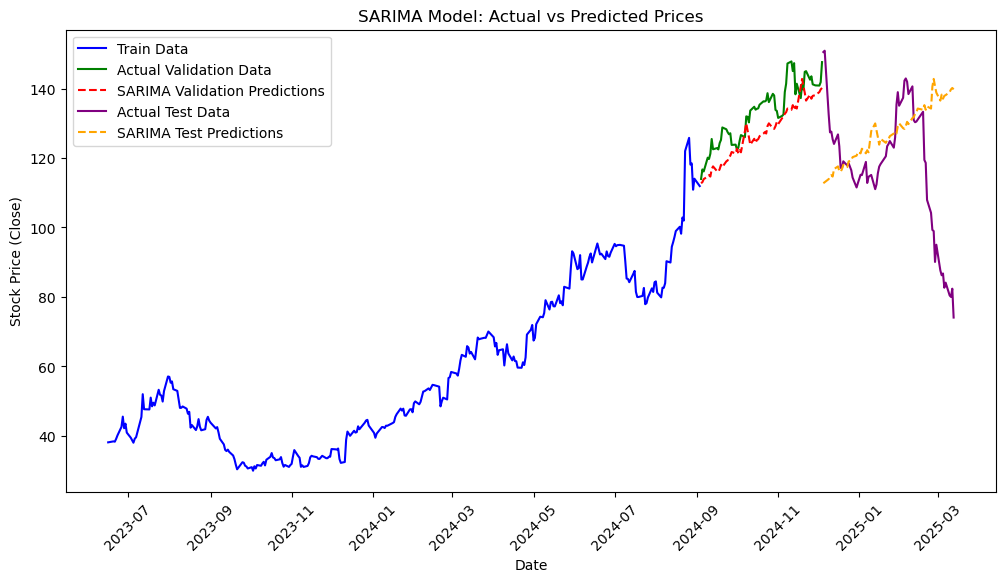

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data["Date"], train_data["Close"], label="Train Data", color="blue")
plt.plot(val_data["Date"], val_data["Close"], label="Actual Validation Data", color="green")
plt.plot(val_data["Date"], val_predicted_mean, label="SARIMA Validation Predictions", color="red", linestyle="dashed")
plt.plot(test_data["Date"], test_data["Close"], label="Actual Test Data", color="purple")
plt.plot(test_data["Date"], test_predicted_mean, label="SARIMA Test Predictions", color="orange", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price (Close)")
plt.title("SARIMA Model: Actual vs Predicted Prices")
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Linear Regression

In [31]:
# Create "Time_Index" before splitting
data_cleaned["Time_Index"] = np.arange(len(data_cleaned))

# Now split the dataset (reusing SARIMA's split)
train_data = data_cleaned.iloc[:train_end]
val_data = data_cleaned.iloc[train_end:val_end]
test_data = data_cleaned.iloc[val_end:]

# Ensure "Time_Index" is present
print(train_data.columns)  # Should include "Time_Index"
print(val_data.columns)  # Should include "Time_Index"
print(test_data.columns)  # Should include "Time_Index"

# Define features and target variable
X_train, y_train = train_data[["Time_Index"]], train_data["Close"]
X_val, y_val = val_data[["Time_Index"]], val_data["Close"]
X_test, y_test = test_data[["Time_Index"]], test_data["Close"]

# Add constant term for OLS regression
X_train = sm.add_constant(X_train)
X_val = sm.add_constant(X_val)
X_test = sm.add_constant(X_test)

Index(['Date', 'Close', 'Close_Diff', 'Close_Diff2', 'Close_Boxcox',
       'Time_Index'],
      dtype='object')
Index(['Date', 'Close', 'Close_Diff', 'Close_Diff2', 'Close_Boxcox',
       'Time_Index'],
      dtype='object')
Index(['Date', 'Close', 'Close_Diff', 'Close_Diff2', 'Close_Boxcox',
       'Time_Index'],
      dtype='object')


In [32]:
# Fit OLS model
model = sm.OLS(y_train, X_train).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     812.3
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           9.71e-88
Time:                        13:23:43   Log-Likelihood:                -1190.7
No. Observations:                 305   AIC:                             2385.
Df Residuals:                     303   BIC:                             2393.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.7285      1.375     17.979      0.0

In [33]:
# Make predictions
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

In [34]:
# Compute evaluation metrics
val_mae = mean_absolute_error(y_val, val_predictions)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, val_predictions)

test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

# Print evaluation metrics
print(f"Validation MAE: {val_mae:.2f}, MSE: {val_mse:.2f}, RMSE: {val_rmse:.2f}, R2: {val_r2:.2f}")
print(f"Test MAE: {test_mae:.2f}, MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")

Validation MAE: 34.29, MSE: 1199.99, RMSE: 34.64, R2: -16.58
Test MAE: 16.00, MSE: 392.80, RMSE: 19.82, R2: -0.29


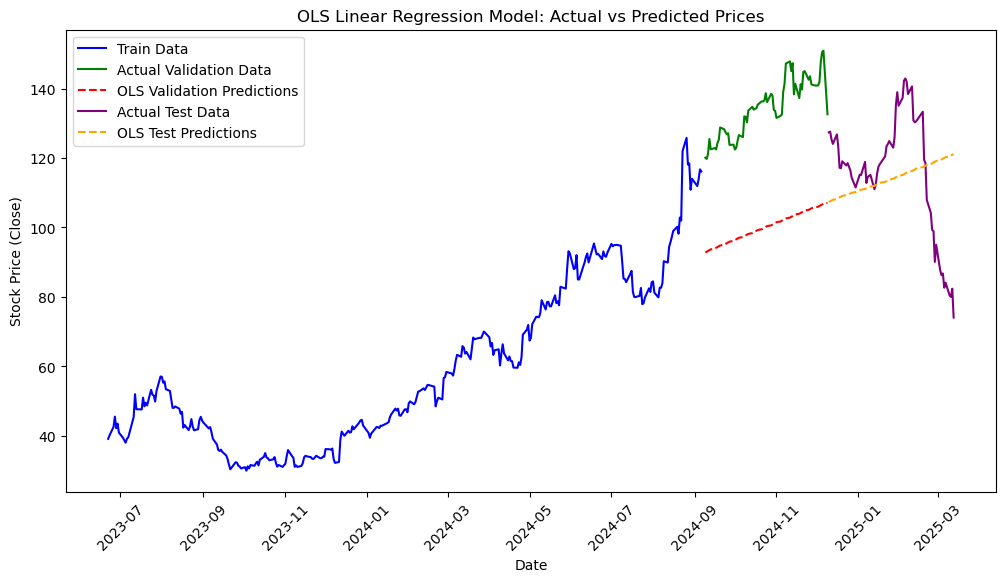

In [35]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data["Date"], train_data["Close"], label="Train Data", color="blue")
plt.plot(val_data["Date"], y_val, label="Actual Validation Data", color="green")
plt.plot(val_data["Date"], val_predictions, label="OLS Validation Predictions", color="red", linestyle="dashed")
plt.plot(test_data["Date"], y_test, label="Actual Test Data", color="purple")
plt.plot(test_data["Date"], test_predictions, label="OLS Test Predictions", color="orange", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price (Close)")
plt.title("OLS Linear Regression Model: Actual vs Predicted Prices")
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Conclusion
In this project, I developed and assessed two predictive models for forecasting CAVA stock prices in this project. The first model showed good performance during the validation stage with a Mean Absolute Error (MAE) of 5.93 and Root Mean Squared Error (RMSE) of 6.85 while obtaining an R² score of 0.37. The model showed poor generalization capabilities on test data evidenced by its high MAE of 17.72 and RMSE of 26.02 along with a negative R² of -1.05. The validation performance of the second model demonstrated much higher errors with MAE at 34.29 and RMSE at 34.64, while the validation R² fell to an extremely poor -16.58, indicating a failure in capturing meaningful relationships. The model displayed slightly reduced test errors with MAE at 16.00, RMSE at 19.82, and R² at -0.29 but remained an underperforming solution.

The results demonstrate that overfitting is present in both models. The models learned patterns from training data but show poor performance when predicting new stock price patterns. The models are likely underperforming because they only consider historical closing prices and ignore wider market patterns as well as economic data and investor emotions. Time-series features including seasonality and trends may have been insufficiently represented which resulted in inconsistent prediction accuracy.

Models can be significantly enhanced by implementing numerous essential modifications. Data normalization enables equal feature contribution across all inputs which is crucial for models dependent on gradient-based optimization techniques. Training becomes more stable and efficient when data scaling is applied because it eliminates large prediction fluctuations. 